# 라이브러리

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import re  
from tensorflow.keras.layers import Embedding, GRU, Dense

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 208906


,eng,fra,cc
41765,You look very tired.,Tu as l'air très fatiguée.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
104578,"Yesterday, I lost my wallet.","Hier, j'ai perdu mon portefeuille.",CC-BY 2.0 (France) Attribution: tatoeba.org #6...
16093,Sweep the floor.,Balaie le sol.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
54550,The two brothers died.,Les deux frères sont morts.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
42866,Don't touch anything.,Ne touchez à rien !,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


동일한 데이터셋을 사용하면서 글자 단위와는 다른 전처리와 to_categorical() 함수가 아닌 임베딩 층(Embedding layer)를 추가하여 단어 단위의 번역기를 완성시켜보겠습니다. 하지만, 단어 단위로 할 경우에는 단어의 개수가 글자 단위로 했을 경우와 비교하여 단어장의 크기(Vocabulary) 크기도 커지고, 학습 속도도 좀 더 느려집니다. 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 ``33,000개의 샘플``만 사용해주세요.

33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

In [3]:
lines = lines[['eng', 'fra']][:33000] # 3.3만개 샘플 사용
lines.sample(5)

,eng,fra
10094,Don't be angry.,Ne soyez pas en colère.
21222,The sky was gray.,Le ciel était gris.
7170,He talks well.,Il parle bien.
22354,We've got a leak.,Nous avons une fuite.
16362,They're all bad.,Ils sont tous mauvais.


# Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)
글자 단위가 아닌 단어 단위의 번역기를 하기 위해서는 글자 단위에서는 신경쓰지 않았던 몇 가지 추가적인 전처리가 필요합니다.

1. 구두점(Punctuation)을 단어와 분리해주세요.
일반적으로 영어권 언어의 경우에는 띄어쓰기 단위로 단어를 분리합니다. 토큰화(Tokenization) 라고도 불리는 이 작업은 어디서부터 어디까지가 하나의 단어인지를 구분하는 작업인데요, 그런데 띄어쓰기를 해주기 전에 구두점을 분리하는 작업이 필요할 때가 있습니다.
예를 들어서 'he is a good boy!'라는 문장이 있을 때, 이를 띄어쓰기 단위로 토큰화한다면 ['he', 'is', 'a', 'good', 'boy!']가 됩니다. 그런데 실제로 !는 boy와 붙어있는 한 단어가 아니므로 좀 더 올바른 전처리는 ['he', 'is', 'a', 'good', 'boy', '!']가 맞습니다.
!나 ? 또는 온점과 같은 특수문자들을 구두점(punctuation)이라고 부릅니다. 이들을 토큰화하기 전에 단어와 미리 분리시켜주세요!

분리 전 : he is a Good boy!

분리 후 : he is a Good boy !

2. 소문자로 바꿔주세요.
기계가 보기에는 스펠링이 같더라도 대문자로 된 단어와 소문자로 된 단어는 서로 다른 단어입니다. 예를 들어 'Good'과 'good'은 기계가 보기에는 다른 단어입니다. 그래서 모든 문장에 대해서 전부 영어로 바꿔주는 작업을 하겠습니다.

변환 전 : he is a Good boy !
변환 후 : he is a good boy !

3. 띄어쓰기 단위로 토큰화를 수행하세요.

띄어쓰기 단위로 토큰화를 수행해서 단어를 분리하는 작업을 해주세요. 기계는 이렇게 분리된 토큰들을 각각 하나의 단어로 인식할 수 있게 됩니다.

토큰화 전 : 'he is a good boy !'


토큰화 후 : ['he', 'is', 'a', 'good', 'boy', '!']

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
  
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    
    sentence = sentence.strip()
    sentence = sentence.split(" ")
    
    return sentence

In [5]:
def preprocess_sentence_decoder(sentence):
    sentence = sentence.lower().strip()
  
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    
    sentence = sentence.strip()
    sentence = '\t ' + sentence + ' \n'
    sentence = sentence.split(" ")
    
    return sentence

In [6]:
lines.eng = lines.eng.apply(lambda x : preprocess_sentence(x))
lines.fra = lines.fra.apply(lambda x : preprocess_sentence_decoder(x))

In [7]:
lines.eng.sample(5)

8209      [it, s, saturday, .]
4323        [where, is, it, ?]
5580       [it, was, clean, .]
12861    [we, re, brothers, .]
1850          [forgive, me, .]
Name: eng, dtype: object

In [8]:
lines.fra.sample(5)

11401    [\t, est, il, en, train, de, dormir, ?, \n]
21503                 [\t, c, est, la, norme, ., \n]
3187                 [\t, j, ai, eu, du, bol, ., \n]
23814             [\t, l, homme, est, mortel, ., \n]
2562          [\t, tom, a, fait, la, grimace, ., \n]
Name: fra, dtype: object

In [9]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(lines.eng)

In [10]:
print(eng_tokenizer.word_index)

{'.': 1, 'i': 2, 'you': 3, '?': 4, 'it': 5, 'tom': 6, 's': 7, 'is': 8, 'a': 9, 're': 10, 'm': 11, 'we': 12, 't': 13, 'that': 14, 'he': 15, 'the': 16, 'me': 17, 'was': 18, 'this': 19, 'to': 20, 'are': 21, '!': 22, 'do': 23, 'can': 24, 'they': 25, 'my': 26, 'go': 27, 'your': 28, 'have': 29, 'don': 30, 'not': 31, 'll': 32, 'be': 33, 'she': 34, 'no': 35, 'let': 36, 'what': 37, 'did': 38, 'here': 39, 'like': 40, 'all': 41, 'in': 42, 'get': 43, 'how': 44, 'up': 45, 'on': 46, 'very': 47, 'need': 48, 'one': 49, 'want': 50, 'him': 51, 'love': 52, 'out': 53, 'please': 54, 'who': 55, 'come': 56, 'know': 57, 'just': 58, 'take': 59, 'stop': 60, 'now': 61, 'so': 62, 'us': 63, 'look': 64, 'there': 65, 'got': 66, 'help': 67, 'of': 68, 'too': 69, 'for': 70, 'good': 71, 'see': 72, 'at': 73, 've': 74, 'will': 75, 'keep': 76, 'am': 77, 'had': 78, 'has': 79, 'were': 80, 'back': 81, 'give': 82, 'stay': 83, 'home': 84, 'saw': 85, 'feel': 86, 'must': 87, 'alone': 88, 'happy': 89, 'where': 90, 'try': 91, 'leav

In [11]:
eng_tokenizer = Tokenizer(char_level=False)   # 단어 단위로 Tokenizer를 생성합니다. True는 문자단위
eng_tokenizer.fit_on_texts(lines.eng)               # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text1 = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text1[:3]

[[27, 1], [27, 1], [27, 1]]

In [12]:
fra_tokenizer = Tokenizer(char_level=False)   # 단어 단위로 Tokenizer를 생성합니다. True는 문자단위
fra_tokenizer.fit_on_texts(lines.fra)               # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text2 = fra_tokenizer.texts_to_sequences(lines.fra)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text2[:3]

[[1, 74, 9, 2], [1, 350, 3, 2], [1, 27, 516, 9, 2]]

In [13]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4619
프랑스어 단어장의 크기 : 7388


In [14]:
eng_tokenizer.word_index

{'.': 1,
 'i': 2,
 'you': 3,
 '?': 4,
 'it': 5,
 'tom': 6,
 's': 7,
 'is': 8,
 'a': 9,
 're': 10,
 'm': 11,
 'we': 12,
 't': 13,
 'that': 14,
 'he': 15,
 'the': 16,
 'me': 17,
 'was': 18,
 'this': 19,
 'to': 20,
 'are': 21,
 '!': 22,
 'do': 23,
 'can': 24,
 'they': 25,
 'my': 26,
 'go': 27,
 'your': 28,
 'have': 29,
 'don': 30,
 'not': 31,
 'll': 32,
 'be': 33,
 'she': 34,
 'no': 35,
 'let': 36,
 'what': 37,
 'did': 38,
 'here': 39,
 'like': 40,
 'all': 41,
 'in': 42,
 'get': 43,
 'how': 44,
 'up': 45,
 'on': 46,
 'very': 47,
 'need': 48,
 'one': 49,
 'want': 50,
 'him': 51,
 'love': 52,
 'out': 53,
 'please': 54,
 'who': 55,
 'come': 56,
 'know': 57,
 'just': 58,
 'take': 59,
 'stop': 60,
 'now': 61,
 'so': 62,
 'us': 63,
 'look': 64,
 'there': 65,
 'got': 66,
 'help': 67,
 'of': 68,
 'too': 69,
 'for': 70,
 'good': 71,
 'see': 72,
 'at': 73,
 've': 74,
 'will': 75,
 'keep': 76,
 'am': 77,
 'had': 78,
 'has': 79,
 'were': 80,
 'back': 81,
 'give': 82,
 'stay': 83,
 'home': 84,
 'saw':

In [15]:
max_eng_seq_len = max([len(line) for line in input_text1])
max_fra_seq_len = max([len(line) for line in input_text2])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [16]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4619
프랑스어 단어장의 크기 : 7388
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


같은 문장을 굳이 2가지 버전으로 나누는 이유는, 디코더의 입력으로 사용할 시퀀스는 <eos> 토큰이 필요가 없고, 디코더의 출력과 비교할 시퀀스는 <sos>가 필요가 없기 때문입니다. 가령, 영어로 'I am a person'이라는 문장을 프랑스어 'Je suis une personne'로 번역하는 번역기를 만든다고 해봅시다. 훈련 과정에서 디코더는 '<sos> Je suis une personne'를 입력받아서 'Je suis une personne <eos>'를 예측하도록 훈련되므로, 이런 방식으로 생성된 두가지 버전의 시퀀스를 준비해야 합니다.

이문제는 <start>이 사전에 없기때문에 문제가 일어났다. 분리함수때문에 이런일이 일어난것 같다.

In [17]:
encoder_input = input_text1
sos_token = '\t'
eos_token = '\n'
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in input_text2] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in input_text2]

In [18]:
print(decoder_input[:5])
print(decoder_target[:5])

[[1, 74, 9], [1, 350, 3], [1, 27, 516, 9], [1, 685, 9], [1, 686, 9]]
[[74, 9, 2], [350, 3, 2], [27, 516, 9, 2], [685, 9, 2], [686, 9, 2]]


In [19]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)


모든 샘플들의 길이가 동일하게 변환된 것을 알 수 있습니다. 모든 샘플들의 길이가 동일하게 변환되는 과정에서 정해준 길이보다 짧은 데이터들은 뒤에 0(<pad>)으로 채워집니다. 인코더의 샘플 하나만 출력해볼까요?

In [20]:
print(encoder_input[0])

[27  1  0  0  0  0  0  0]


In [21]:
print(decoder_input[0])

[ 1 74  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [22]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4619
프랑스어 단어장의 크기 : 7388
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [23]:
# encoder_input = to_categorical(encoder_input)
# decoder_input = to_categorical(decoder_input)
# decoder_target = to_categorical(decoder_target)
# print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
# print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
# print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

# train,val셋 분리

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(30000, 8)
(30000, 17)
(30000, 17)
(3000, 8)
(3000, 17)
(3000, 17)


In [26]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

print('⏳')

⏳


In [27]:
# from keras.layers import Input, LSTM, Embedding, Reshape

# embedding_size = 512
# hidden_size = 512
# # 인코더에서 사용할 임베딩 층 사용 예시
# encoder_inputs = Input(shape=(max_eng_seq_len, ), name='encoder_input')
# encoder_inputs_reshaped = Reshape((max_eng_seq_len, 1))(encoder_inputs)

# enc_emb =  Embedding(eng_vocab_size, embedding_size,
#                     input_length=max_eng_seq_len)(encoder_inputs_reshaped)
# encoder_lstm = LSTM(hidden_size, dropout = 0.3, return_state=True)
# encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# encoder_states = [state_h, state_c]

In [28]:
from keras.layers import Input, LSTM, Embedding, Reshape , Masking
embedding_size = 256
hidden_size = 128
# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None, ), name='encoder_input')
enc_emb =  Embedding(eng_vocab_size, embedding_size)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_size, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

In [29]:
decoder_inputs = Input(shape=(None, ), name='decoder_input')
dec_emb_layer =  Embedding(fra_vocab_size, embedding_size)
dec_emb = dec_emb_layer(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state = encoder_states)

In [30]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [31]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy')

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1182464     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    1891328     decoder_input[0][0]              
______________________________________________________________________________________________

In [33]:
history= model.fit(x=[encoder_input_train, decoder_input_train], 
          y=decoder_target_train, 
          validation_data = ([encoder_input_test, decoder_input_test], 
                             decoder_target_test),
          batch_size=128, 
          epochs=50)

Epoch 1/50
235/235 [==============================] - 14s 27ms/step - loss: 2.0959 - val_loss: 1.5099
Epoch 2/50
235/235 [==============================] - 4s 19ms/step - loss: 1.4089 - val_loss: 1.3260
Epoch 3/50
235/235 [==============================] - 4s 19ms/step - loss: 1.2409 - val_loss: 1.1971
Epoch 4/50
235/235 [==============================] - 4s 19ms/step - loss: 1.1202 - val_loss: 1.1030
Epoch 5/50
235/235 [==============================] - 4s 19ms/step - loss: 1.0336 - val_loss: 1.0368
Epoch 6/50
235/235 [==============================] - 4s 19ms/step - loss: 0.9652 - val_loss: 0.9884
Epoch 7/50
235/235 [==============================] - 4s 19ms/step - loss: 0.9077 - val_loss: 0.9598
Epoch 8/50
235/235 [==============================] - 4s 19ms/step - loss: 0.8572 - val_loss: 0.9089
Epoch 9/50
235/235 [==============================] - 4s 19ms/step - loss: 0.8124 - val_loss: 0.8819
Epoch 10/50
235/235 [==============================] - 4s 19ms/step - loss: 0.7712 - val_l

dict_keys(['loss', 'val_loss'])


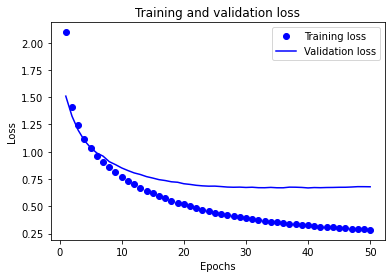

In [34]:
history_dict = history.history
print(history_dict.keys())
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, 50+1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [35]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         1182464   
_________________________________________________________________
masking (Masking)            (None, None, 256)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 128), (None, 128) 197120    
Total params: 1,379,584
Trainable params: 1,379,584
Non-trainable params: 0
_________________________________________________________________


In [36]:
# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(128,))
decoder_state_input_c = Input(shape=(128,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)




In [37]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    1891328     decoder_input[0][0]              
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
____________________________________________________________________________________________

In [38]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [39]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0]= fra2idx['\t']

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' ' + sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) >  50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [40]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['\t']) and i!=fra2idx['\n']):
            temp = temp + idx2fra[i] + ' '
    return temp

In [45]:
input_seq

array([[  2, 144,  33,  89,   1,   0,   0,   0]], dtype=int32)

# 번역 학습 보기

In [42]:
for seq_index in [3, 50, 100, 300, 1001]:
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print("입력문장 :",seq2src(encoder_input_train[seq_index]))
    print("정답문장 :",seq2tar(decoder_input_train[seq_index]))
    print("번역문장 :",decoded_sentence[1:-6])
    print("-"*50)

입력문장 : a boat capsized . 
정답문장 : un bateau chavira . 
번역문장 : un bateau a lo
--------------------------------------------------
입력문장 : i own a yacht . 
정답문장 : je poss de un bateau de plaisance . 
번역문장 : je poss de un bateau de je
--------------------------------------------------
입력문장 : let me go . 
정답문장 : laisse moi m en aller ! 
번역문장 : laissez moi part
--------------------------------------------------
입력문장 : i wish you luck . 
정답문장 : je te souhaite bonne chance . 
번역문장 : je vous souhaite bonne chan
--------------------------------------------------
입력문장 : we re very busy . 
정답문장 : nous sommes fort occup s . 
번역문장 : nous sommes tr s occup 
--------------------------------------------------


# 번역 test

In [44]:
for seq_index in [1,3,501,122,545]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print("번역문장 :",decoded_sentence[1:-6])

-----------------------------------
입력 문장: describe tom . 
정답 문장: d cris tom . 
번역문장 : tom
-----------------------------------
입력 문장: is less than . 
정답 문장: cinq est plus petit que huit . 
번역문장 : il n y a beaucoup de quelque cho
-----------------------------------
입력 문장: they struggled . 
정답 문장: ils ont eu du mal . 
번역문장 : elles ont se mal
-----------------------------------
입력 문장: tom shot at mary . 
정답 문장: tom a tir sur mary . 
번역문장 : tom a tir sur sur le ma
-----------------------------------
입력 문장: i should be happy . 
정답 문장: je devrais tre heureuse . 
번역문장 : je devrais tre heure


# 회고 

-----------------------------------
입력 문장: describe tom . 
정답 문장: d cris tom . 
번역문장 : tom
-----------------------------------
입력 문장: is less than . 
정답 문장: cinq est plus petit que huit . 
번역문장 : il n y a beaucoup de quelque cho
-----------------------------------
입력 문장: they struggled . 
정답 문장: ils ont eu du mal . 
번역문장 : elles ont se mal
-----------------------------------
입력 문장: tom shot at mary . 
정답 문장: tom a tir sur mary . 
번역문장 : tom a tir sur sur le ma
-----------------------------------
입력 문장: i should be happy . 
정답 문장: je devrais tre heureuse . 
번역문장 : je devrais tre heure

시간이 너무 많이 걸렸다. 노드에 있는 걸 따라했지만, 갖은 오류에 정신을 잃고 말았다.

좀더 검색을 하여 노드에 있는 것 말고, 최적의 코드를 알려주셔서 코드를 변형시켜보았다.

masking을 사용하여 padding에 학습되지 않게 하는것을 깨달았다.

임베딩 레이어에 대해 조금이나마 알수있었다.

layer를 만들고 거기에 다시 인풋을 넣어서 임베딩이라는 변수를 하는것이 보였다.


```공부를 열심히해야겠다.```
